Best val_loss: 4.99509769724682e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
{'RMSE': 0.010315892204162038, 'MAE': 0.007532791830207938, 'R2': -0.11351928125294775, 'DA': 0.4657534246575342}


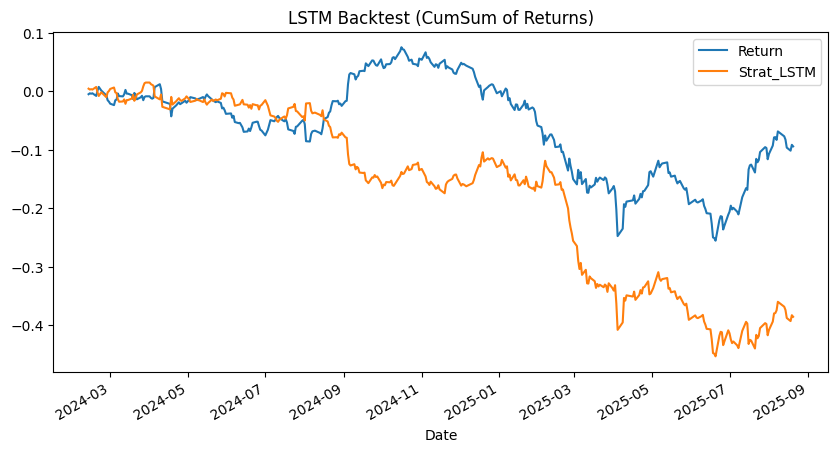

In [ ]:
# --- Setup ---
%pip -q install pandas numpy matplotlib scikit-learn tensorflow==2.*

import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, models, callbacks

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

df = pd.read_csv("dataset_features_labels.csv", index_col=0, parse_dates=True)
features = [c for c in df.columns if c != "Target"]
X, y = df[features].values, df["Target"].values

# time split
n = len(df); n_train = int(n*0.7); n_val = int(n*0.85)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_val], y[n_train:n_val]
X_test,  y_test  = X[n_val:], y[n_val:]

# scale (fit on train only)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train); X_val_s = scaler.transform(X_val); X_test_s = scaler.transform(X_test)

# make sequences
def make_seq(X, y, win=20):
    xs, ys = [], []
    for i in range(win, len(X)):
        xs.append(X[i-win:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

WIN = 20
Xtr, ytr = make_seq(X_train_s, y_train, WIN)
Xva, yva = make_seq(X_val_s,   y_val,   WIN)
Xte, yte = make_seq(X_test_s,  y_test,  WIN)

def build_lstm(input_shape=(WIN, X.shape[1]), units=64, dropout=0.2):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return m

model = build_lstm((WIN, X.shape[1]))
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
hist = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=100, batch_size=64, callbacks=[es], verbose=0)
print("Best val_loss:", min(hist.history["val_loss"]))

# evaluate
yhat = model.predict(Xte).ravel()
rmse = float(np.sqrt(mean_squared_error(yte, yhat)))
mae  = float(mean_absolute_error(yte, yhat))
r2   = float(r2_score(yte, yhat))
da   = float((np.sign(yte) == np.sign(yhat)).mean())
print({"RMSE": rmse, "MAE": mae, "R2": r2, "DA": da})

# simple backtest
idx_test = df.index[n_val+WIN:]  # align with yte timeline
bt = pd.DataFrame(index=idx_test)
bt["Return"] = yte
bt["Sig_LSTM"] = np.where(yhat>0, 1, -1)
bt["Strat_LSTM"] = bt["Sig_LSTM"] * bt["Return"]
bt[["Return","Strat_LSTM"]].cumsum().plot(figsize=(10,5), title="LSTM Backtest (CumSum of Returns)")
plt.show()

pd.DataFrame([{"RMSE":rmse,"MAE":mae,"R2":r2,"DA":da}]).to_csv("lstm_metrics_test.csv", index=False)
bt.to_csv("backtest_lstm.csv")
